In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from sklearn.model_selection import train_test_split

In [4]:
BASE_DIR = 'archive/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(BASE_DIR) if '.' not in i]
classes

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [5]:
image_paths = []
image_classes = np.array([[cls]*1000 for cls in classes]).reshape(-1)
for cls in classes:
    image_paths.extend([os.path.join(BASE_DIR, cls,cls, i) for i in os.listdir(os.path.join(BASE_DIR, cls,cls))])

In [6]:
img_shape = (590 , 445, 3)

In [7]:
data = pd.DataFrame({'path':image_paths, 'class':image_classes, })
data.head()

,path,class
0,archive/Fish_Dataset/Fish_Dataset\Black Sea Sp...,Black Sea Sprat
1,archive/Fish_Dataset/Fish_Dataset\Black Sea Sp...,Black Sea Sprat
2,archive/Fish_Dataset/Fish_Dataset\Black Sea Sp...,Black Sea Sprat
3,archive/Fish_Dataset/Fish_Dataset\Black Sea Sp...,Black Sea Sprat
4,archive/Fish_Dataset/Fish_Dataset\Black Sea Sp...,Black Sea Sprat


In [8]:
def get_generators(data, is_rgb =True):
    color_mode = 'rgb' if is_rgb else 'grayscale'
    data_full, data_remainder = train_test_split(data, stratify = data['class'], test_size = 0.2)
    train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.1)

    test_datagen = ImageDataGenerator(rescale = 1.0/255)
    train_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
         target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='training'
        )
    val_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
         target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='validation'
        )
    test_generator = test_datagen.flow_from_dataframe(data_remainder, x_col = 'path', y_col = 'class', target_size = img_shape[:-1], color_mode = color_mode,class_mode = 'categorical')
    return train_generator, val_generator, test_generator

In [9]:
train_gen, val_gen, test_gen = get_generators(data)

Found 6480 validated image filenames belonging to 9 classes.
Found 720 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [18]:
model = Sequential([
    Conv2D(16,(3,3), strides = 3, input_shape = img_shape),
    MaxPooling2D(),
    Conv2D(32, (3,3),strides=2),
    
    MaxPooling2D(),
    Conv2D(64, (3,3)),
    MaxPooling2D(),
    Conv2D(64,(3,3)),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    Dense(9, activation = 'softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 196, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 98, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 36, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 22, 16, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 8, 64)       

In [16]:
earlystop = EarlyStopping(patience = 10,restore_best_weights=True )
schedule = ExponentialDecay(initial_learning_rate = 0.002, decay_steps = 1000, decay_rate = 0.7)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate =schedule), metrics = ['accuracy'])
history = model.fit(train_gen, validation_data = val_gen,epochs = 20, callbacks = [earlystop])

Epoch 1/20
203/203 [==============================] - 110s 539ms/step - loss: 0.2673 - accuracy: 0.9069 - val_loss: 0.1252 - val_accuracy: 0.9556
Epoch 2/20
203/203 [==============================] - 110s 542ms/step - loss: 0.2441 - accuracy: 0.9157 - val_loss: 0.1420 - val_accuracy: 0.9569
Epoch 3/20
203/203 [==============================] - 94s 463ms/step - loss: 0.1938 - accuracy: 0.9316 - val_loss: 0.1202 - val_accuracy: 0.9514
Epoch 4/20
203/203 [==============================] - 78s 384ms/step - loss: 0.1617 - accuracy: 0.9438 - val_loss: 0.1479 - val_accuracy: 0.9583
Epoch 5/20
203/203 [==============================] - 77s 381ms/step - loss: 0.1996 - accuracy: 0.9340 - val_loss: 0.0504 - val_accuracy: 0.9833
Epoch 6/20
203/203 [==============================] - 80s 396ms/step - loss: 0.1309 - accuracy: 0.9560 - val_loss: 0.0530 - val_accuracy: 0.9806
Epoch 7/20
203/203 [==============================] - 80s 394ms/step - loss: 0.1226 - accuracy: 0.9593 - val_loss: 0.0810 - val_

In [17]:
model.evaluate(test_gen)

57/57 [==============================] - 18s 307ms/step - loss: 0.0166 - accuracy: 0.9967


[0.01655295118689537, 0.996666669845581]

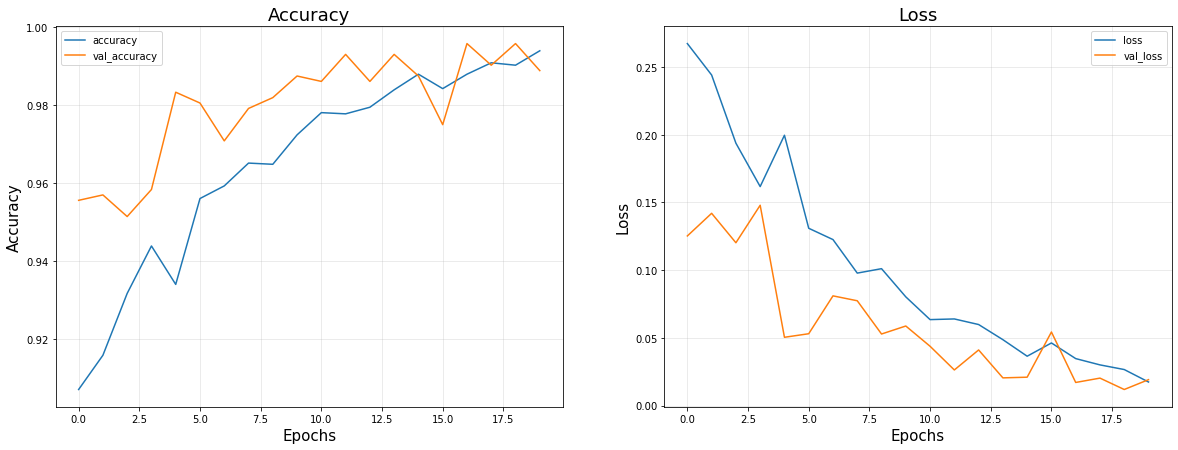

In [20]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['accuracy'], label = "accuracy")
plt.plot(history.epoch, history.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()
